In [1]:
import numpy as np
import torch
from tqdm.notebook import tqdm
import pickle
import copy
from pprint import pprint

from jeffutils.utils import reimport
import os
os.chdir("..")
from models.old_pytorch_model import OrigamiNetwork
from models.model_bank import OrigamiToy2
from models.training import *
reimport("from models.old_pytorch_model import OrigamiNetwork", globals())
reimport("from models.model_bank import OrigamiToy2", globals())
reimport("from models.training import *", globals())
from vis_helpers import *
reimport("../from vis_helpers import *", globals())

### Data

In [2]:
def layer_sam(D, n):
    scales = (D@n)/np.dot(n, n)
    mask = scales > 1
    return D + mask[:,np.newaxis] * (2*n - (2 * np.outer(scales, n)))
fv1 = np.array([0,.5])
size = 10
X1, X2 = np.meshgrid(np.linspace(-2,2,size), np.linspace(-2,2,size))
sandwichX = np.concatenate((X1.reshape(-1,1), X2.reshape(-1,1)), axis=1)
sandwichY = layer_sam(sandwichX, fv1)[:,1] > -.5
# plt.scatter(sandwichX[:,0], sandwichX[:,1], c=sandwichY)
sandwichX = torch.tensor(sandwichX, dtype=torch.float32)
sandwichY = torch.tensor(sandwichY, dtype=torch.float32)

size = 20
x1 = np.linspace(-2,2,size)
x2 = np.linspace(-2,2,size)
X1,X2 = np.meshgrid(x1,x2)
xorX = np.concatenate((X1.reshape(-1,1),X2.reshape(-1,1)),axis=1)
xorY = np.array([[1 if (i < size//2 and j < size//2 or i >= size//2 and j >= size//2) else 0 for j in range(size)] for i in range(size)]).reshape(-1)
# plt.scatter(xorX[:,0], xorX[:,1], c=xorY)
xorX = torch.tensor(xorX, dtype=torch.float32)
xorY = torch.tensor(xorY, dtype=torch.float32)

count = 20
onedX = np.linspace(-2,2,count)
onedY = np.zeros(count)
onedY[:6] = 1
onedY[-6:] = 1
onedX = np.expand_dims(onedX, axis=1)
onedX = torch.tensor(onedX, dtype=torch.float32)
onedY = torch.tensor(onedY, dtype=torch.float32)

In [3]:
# make 300 points normally distributed around 0,0 with std 1
size = 300
eggX = np.random.randn(size, 2)
eggY = np.linalg.norm(eggX, axis=1) > 1

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the star
num_points = 5
outer_radius = 2
inner_radius = 0.7

# Generate the star coordinates
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
x_star = []
y_star = []

for i in range(num_points):
    # Outer points
    x_star.append(outer_radius * np.cos(angles[i]))
    y_star.append(outer_radius * np.sin(angles[i]))
    
    # Inner points
    x_star.append(inner_radius * np.cos(angles[i] + np.pi / num_points))
    y_star.append(inner_radius * np.sin(angles[i] + np.pi / num_points))

# Close the loop by repeating the first point
x_star.append(x_star[0])
y_star.append(y_star[0])

# Create the squareX array
size = 400  # You can adjust the number of points
squareX = np.random.rand(size, 2) * 4 - 2  # Points inside a square from -2 to 2

# Function to check if a point is inside the star
def is_point_in_star(x, y):
    # Check if the point lies within the boundaries of the star by using a ray-casting method
    n = len(x_star)
    inside = False
    p1x, p1y = x_star[0], y_star[0]
    for i in range(n):
        p2x, p2y = x_star[i], y_star[i]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Create the array Y to check if points are inside the star
Y = np.array([1 if is_point_in_star(x, y) else 0 for x, y in squareX])

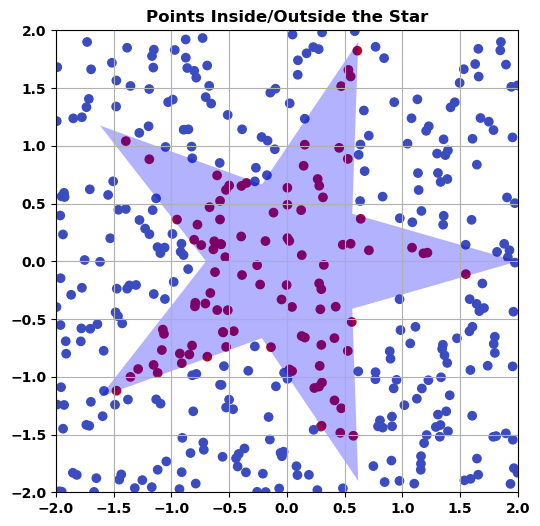

In [ ]:
# Plot the points and the star
plt.figure(figsize=(6, 6))
plt.scatter(squareX[:, 0], squareX[:, 1], c=Y, cmap='coolwarm')  # Color points by Y
# plt.fill(x_star, y_star, 'b', alpha=0.3)  # Fill the star shape
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Points Inside/Outside the Star")
plt.grid(True)
plt.show()

## Training

In [13]:
test_case_x = squareX
test_case_y = Y
print("Testing xor problem")
layers = 3
test = OrigamiNetwork(n_layers=layers, width=None, epochs=100, 
                      learning_rate=0.01, optimizer_type="adam", crease=0)
test.load_data(test_case_x, test_case_y)
# test.set_folds([np.array([-0.00466453, 0.53786325])])
test.fit()
# logits = test.forward(test_case_x)

# # print("\nScore =", test.score(), "after training")
print("Cut", test.get_cut_vector(), "Fold vectors", sep="\n")
pprint(test.get_fold_vectors())
print("Done")

Testing xor problem


Train Accuracy: 0.9: 100%|██████████| 100/100 [00:03<00:00, 25.30it/s]  

Cut
[[ 1.6906679  1.3497989]
 [-2.1973212 -1.6284428]]
Fold vectors
{'Layer 0': {'hyperplane': [-0.096, -0.035]},
 'Layer 1': {'hyperplane': [0.008, -0.174]},
 'Layer 2': {'hyperplane': [-0.192, 0.065]}}
Done


In [38]:
learning_rate = 0.0005
n_epochs = 300
verbose = 1
model = OrigamiToy2()


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loader = load_data(squareX, star)
val_loader = load_data(squareX, star)
train_losses, val_losses, train_accuracies, val_accuracies, *learning_rates = train(model, optimizer, train_loader, val_loader, 
                                                                    validate_rate=0.05, epochs=n_epochs, verbose=verbose)

Training: Epoch:163/300, Loss:0.7651:  54%|█████▍    | 163/300 [00:10<00:08, 15.80it/s]

Early stopping at epoch 163


In [6]:
# reimport("from vis_helpers import *", globals())
plot_star_icml(model, squareX, star, range(4), "Star")

NameError: name 'model' is not defined

In [5]:
# reimport("from vis_helpers import *", globals())
# folds, cuts, creases, trains, vals = test.get_history()
# for l in range(layers):
#     plot_wiggles(fold_histories=folds, crease_histories=creases, train_histories=trains, layer=l)

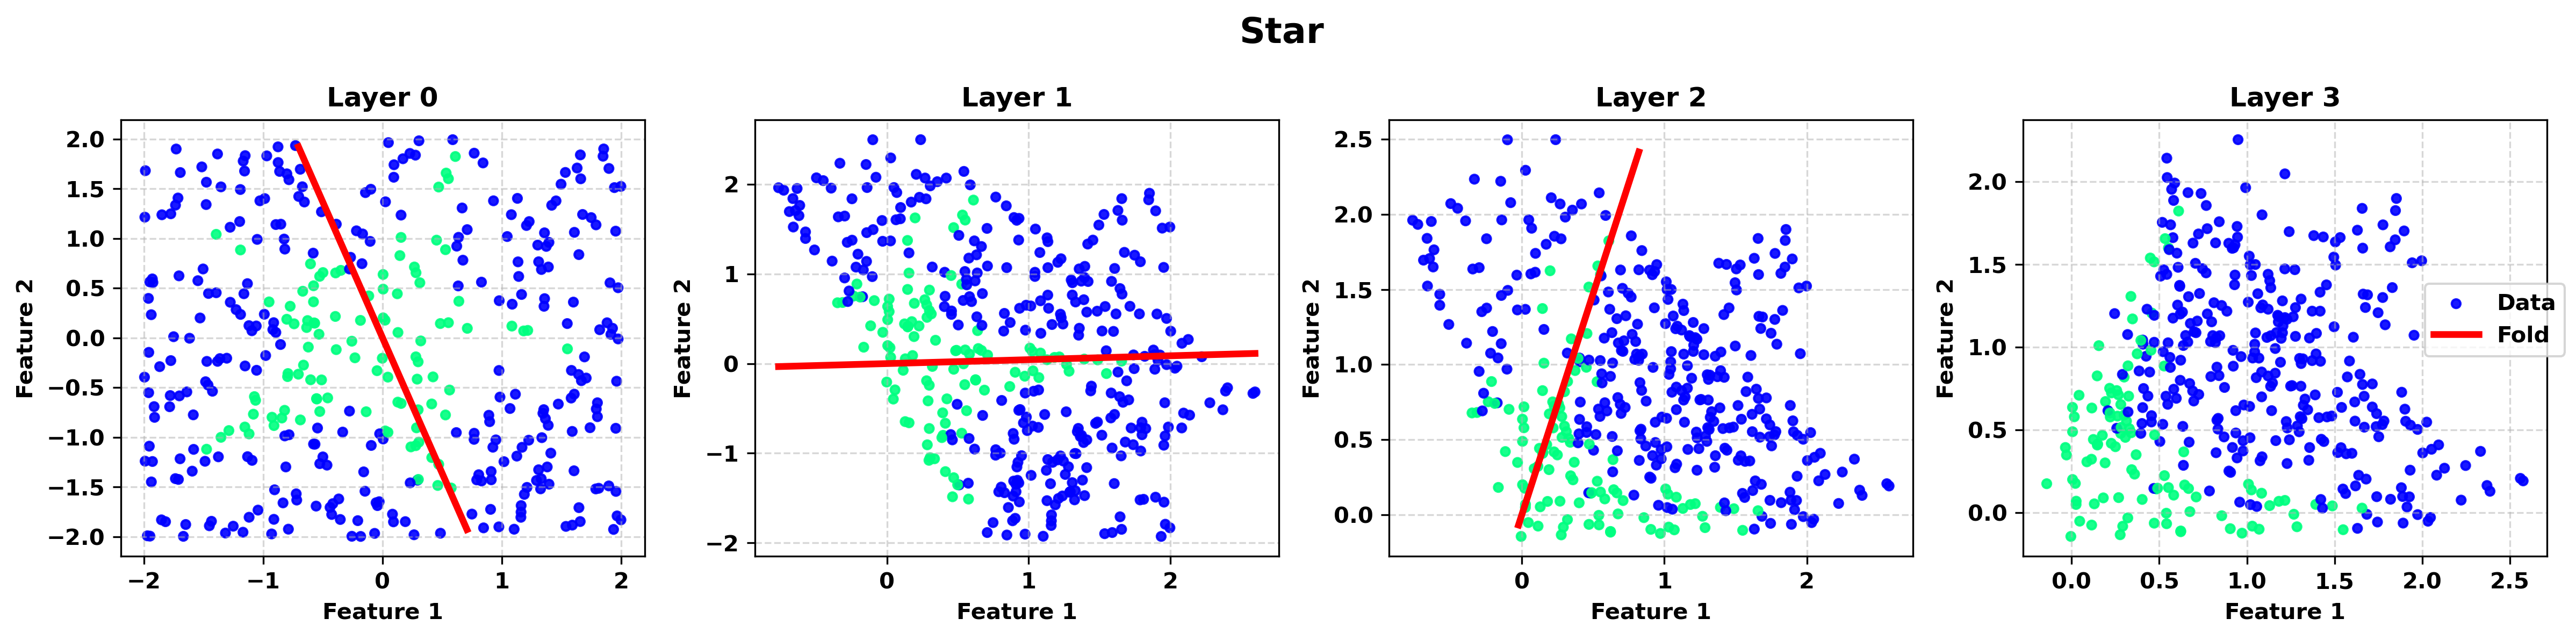

In [14]:
# Visualize folds at each layer
# reimport("from models.pytorch_model_old import OrigamiNetwork", globals())
reimport("from vis_helpers import *", globals())
plot_folds_icml(test, range(layers+1), "Star")

Plotting: 100%|██████████| 50/50 [00:00<00:00, 1351.62it/s]


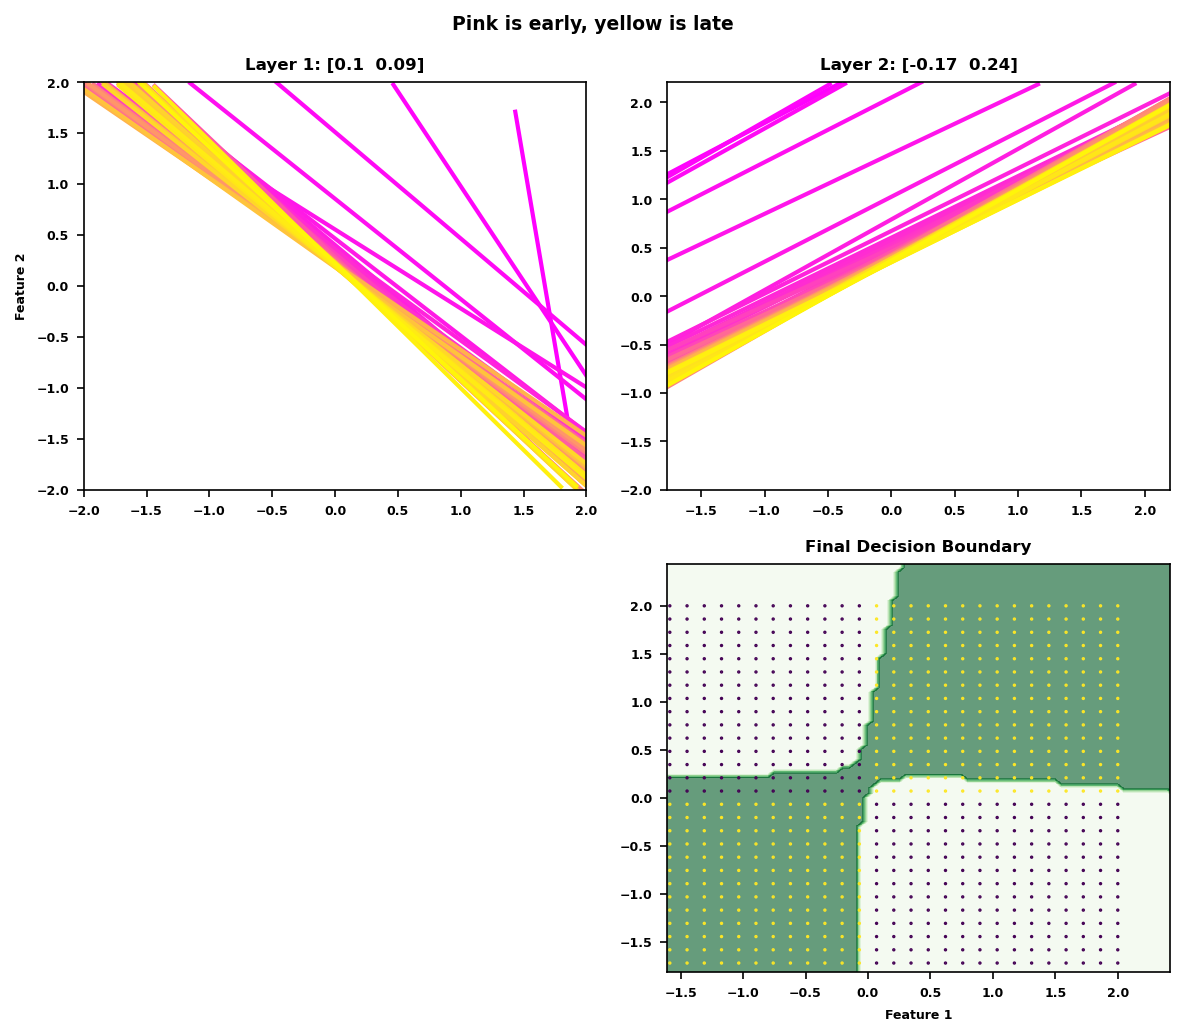

In [6]:
reimport("from vis_helpers import *", globals())
plot_history(test, verbose=2)

In [7]:
pprint(test.get_fold_vectors())

{'Layer 0': {'crease': [-7.595], 'hyperplane': [0.102, 0.092]},
 'Layer 1': {'crease': [-4.057], 'hyperplane': [-0.177, 0.241]}}


In [8]:
reimport("from vis_helpers import *", globals())
max_score, best_folds = create_landscape(test, landscape_type="Score", density=61, verbose=1)
max_score, best_folds = create_landscape(test, landscape_type="Loss", density=61, verbose=1)

Score Layer 0: 100%|██████████| 3721/3721 [00:04<00:00, 749.21it/s]


Score Layer 1: 100%|██████████| 3721/3721 [00:03<00:00, 1001.35it/s]


Loss Layer 0: 100%|██████████| 3721/3721 [00:03<00:00, 936.11it/s] 


Loss Layer 1: 100%|██████████| 3721/3721 [00:03<00:00, 963.60it/s] 


In [9]:
gradient_landscape(test, density=62, invert=True)

Gradient Layer 0: 100%|██████████| 3844/3844 [00:10<00:00, 366.13it/s]


Gradient Layer 1: 100%|██████████| 3844/3844 [00:10<00:00, 371.71it/s]
